In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scan, simulate_data
import os
import time
import json
import pandas as pd

In [6]:
M,N,D,T = 4,30,31,1000
noise =  int(N*5*T/1000)
seed = 0
default_params = {
    'M':M,
    'N':N,
    'D':D,
    'T':T,
    'seed':seed,
    'noise':noise,
    'SM_repetitions':4,
    'spikes_in_SM':10
}

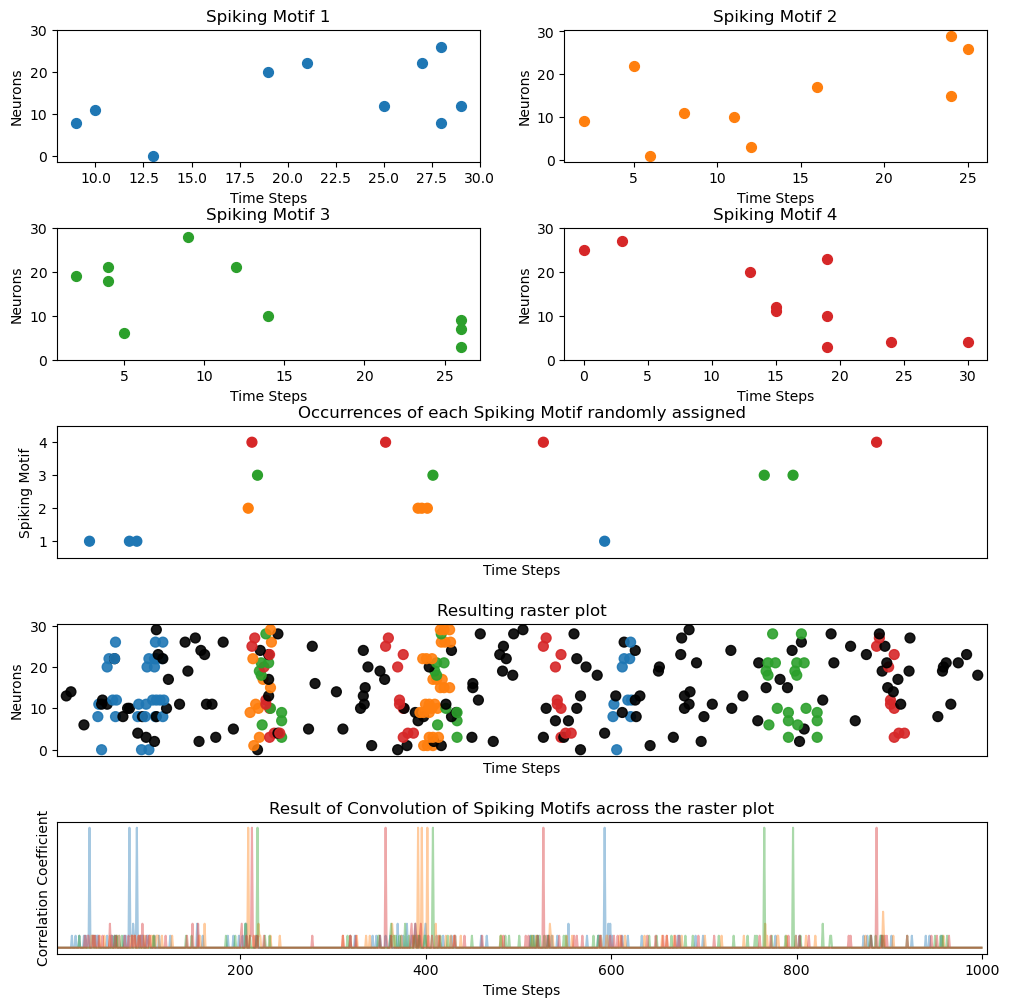

In [8]:
A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse = simulate_data.generate_synthetic_data(default_params, plot=True)

In [48]:
pattern_template, all_times, window_time, cluster_time, sequence_time, opt_cutoff = scan.scan_raster(spikes[0], spikes[1])

309 Windows
10 patterns found...... 90% 10.01 | opt_cutoff - 1.37 | most_detections - 3etections - 3
Building templates... 90%

In [21]:

# === Imports ===
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataclasses import dataclass
from typing import List, Dict, Tuple, Set, Iterable, Optional
import math
np.set_printoptions(edgeitems=5, linewidth=120, suppress=True)

In [28]:
spikes = np.array(A_sparse[:2])[::-1] # Only take the spikes times and neuron_id, reverse the order such: ( spike times, neuron id )
spikes.shape

(2, 310)

In [29]:
spikes

array([[ 51,  94, 102, 219, 370, 567, 606, 215, 342, 380, 398, 402, 408, 417, 642, 108, 156, 409, 473, 697, 803,  99,
        174, 221, 232, 245, 376, 404, 408, 414, 434, 450, 527, 546, 549, 667, 791, 822, 905,  90, 237, 241, 243, 381,
        387, 551, 557, 593, 910, 916, 193, 274, 311, 808,  32, 224, 413, 770, 801, 245, 392, 434, 540, 554, 758, 791,
        822, 863,  47,  66,  74,  90,  95,  98, 109, 110, 117, 398, 428, 602, 621, 627, 700, 952, 211, 245, 389, 394,
        398, 404, 433, 434, 612, 791, 822,  79,  81, 121, 220, 232, 233, 330, 376, 377, 403, 407, 413, 422, 530, 546,
        563, 679, 730, 779, 810, 905,  48,  51,  57,  91,  99, 135, 164, 170, 217, 228, 334, 372, 400, 404, 410, 422,
        542, 603, 684, 709, 901, 912, 966,  52,  63,  67, 106, 110, 114, 118, 228, 372, 457, 542, 618, 622, 626, 828,
        901,  13, 231, 333, 567, 605, 631, 679, 742,  18, 304, 685, 904, 233, 335, 416, 420, 426, 451, 767, 790, 898,
        281, 451, 123, 225, 231, 356, 408, 412, 418, 782

In [44]:

# === Parameters (edit these) ===
# If you already have `spikes` defined as (2, n) [times_ms, neuron_ids], leave it as is.
# Otherwise, uncomment the generator above or load your data here.

# Required: bin size and window length for pattern mining
dt_ms = 1.0                 # raster bin width (ms)
window_bins = 20            # K: number of bins in each sliding window
min_support = 2             # minimum number of window occurrences for a pattern to be considered frequent
max_itemset_size = None        # optional cap on pattern size to keep mining tractable (None for no cap)

# Surrogate / significance settings
n_surrogates = 1           # number of dither surrogates for pattern-spectrum (keep small for demo; raise for real use)
dither_halfwidth_bins = 1   # J: +/- jitter range in bins (e.g., 5 bins = +/- 5 ms if dt_ms=1)
alpha = 0.05                # FDR target for PSF; used also as per-test threshold in PSR demo
psr_h = 0                   # SPADE paper uses h=0
psr_k = 2                   # SPADE paper uses k=2

# If you generated synthetic data above, ensure `spikes` exists.
try:
    spikes  # noqa: F821
except NameError:
    print("Note: `spikes` is not defined. Either run the synthetic generator cell or load your data into a (2, n) array named `spikes`.")


In [30]:

def bin_spikes(spikes_2xn: np.ndarray, dt_ms: float, t_start_ms: Optional[float]=None, t_end_ms: Optional[float]=None):
    """
    Convert (2, n) spikes [times_ms; neuron_id] to a binary raster of shape (N, B).
    - Enforces at most one spike per neuron per bin via clipping to {0,1}.
    Returns: raster (bool array), bin_edges_ms (length B+1), neuron_count N
    """
    assert spikes_2xn.shape[0] == 2, "Input must be (2, n): [times_ms; neuron_ids]"
    times_ms = spikes_2xn[0]
    neuron_ids = spikes_2xn[1].astype(int)
    N = int(neuron_ids.max()) + 1 if neuron_ids.size > 0 else 0
    if t_start_ms is None:
        t_start_ms = 0.0 if times_ms.size == 0 else float(np.floor(times_ms.min()))
    if t_end_ms is None:
        t_end_ms = float(np.ceil(times_ms.max())) if times_ms.size > 0 else 0.0
    if t_end_ms < t_start_ms:
        t_end_ms = t_start_ms
    B = int(np.ceil((t_end_ms - t_start_ms) / dt_ms))
    bin_edges_ms = t_start_ms + np.arange(B+1) * dt_ms
    raster = np.zeros((N, B), dtype=bool)
    if times_ms.size == 0 or N == 0 or B == 0:
        return raster, bin_edges_ms, N
    # Bin indices
    bin_idx = ((times_ms - t_start_ms) / dt_ms).astype(int)
    mask = (bin_idx >= 0) & (bin_idx < B) & (neuron_ids >= 0) & (neuron_ids < N)
    bin_idx = bin_idx[mask]
    neuron_ids = neuron_ids[mask]
    # Set raster; clip multi-hits to 1
    raster[neuron_ids, bin_idx] = True
    return raster, bin_edges_ms, N

# Example usage (if you have `spikes`):
raster, bin_edges_ms, N = bin_spikes(spikes, dt_ms)
raster.shape, N


((30, 982), 30)

In [31]:

def make_transactions(raster: np.ndarray, window_bins: int) -> Tuple[List[Set[int]], int]:
    """
    Build transactions from raster using a sliding window of `window_bins` bins.
    Each transaction is a set of integer-encoded attributes a = i*K + kappa where
    i = neuron index, kappa = local time within the window [0..K-1].
    Returns:
      - transactions: list of sets
      - K: the window_bins (redundant, but helpful for decoding)
    """
    N, B = raster.shape
    K = int(window_bins)
    if K <= 0:
        return [], K
    transactions: List[Set[int]] = []
    # For each window start tau in [0 .. B-K]
    for tau in range(0, B - K + 1):
        # Collect (i, kappa) where spike present
        attrs = set()
        # Find indices where any spike in window
        # Vectorized: find all (i,b) spikes, then map to kappa=b-tau in [0..K-1]
        # But to keep it readable:
        window = raster[:, tau:tau+K]
        is_i, is_kappa = np.where(window)
        for i, kappa in zip(is_i, is_kappa):
            attr = int(i * K + kappa)
            attrs.add(attr)
        transactions.append(attrs)
    return transactions, K

def decode_attr(attr: int, K: int) -> Tuple[int, int]:
    return (attr // K, attr % K)

# Example (after binning):
tx, K = make_transactions(raster, window_bins)
len(tx), K, len(tx[0]) if tx else None


(963, 20, 3)

In [32]:

@dataclass(frozen=True)
class Pattern:
    items: frozenset  # of int attributes
    extent: np.ndarray  # window indices (occurrence windows)
    size: int           # z = |items|
    support: int        # c = |extent|

def _build_inverted_index(transactions: List[Set[int]]) -> Dict[int, np.ndarray]:
    """Return dict: item -> sorted array of transaction indices where item occurs."""
    item_to_idxs: Dict[int, List[int]] = {}
    for t_idx, trans in enumerate(transactions):
        for a in trans:
            item_to_idxs.setdefault(a, []).append(t_idx)
    return {a: np.array(sorted(v), dtype=int) for a, v in item_to_idxs.items()}

def _intersect_extents(extents: Iterable[np.ndarray]) -> np.ndarray:
    extents = list(extents)
    if not extents:
        return np.array([], dtype=int)
    # Start with the smallest to intersect efficiently
    extents.sort(key=lambda x: x.size)
    res = extents[0]
    for e in extents[1:]:
        res = np.intersect1d(res, e, assume_unique=True)
        if res.size == 0:
            break
    return res

def apriori_closed_patterns(transactions: List[Set[int]], min_support: int, max_size: Optional[int]=None) -> List[Pattern]:
    """
    Simple Apriori miner that returns only **closed** frequent itemsets as Pattern objects.
    - Uses extent intersections to compute supports efficiently.
    - After mining all sizes, filters non-closed sets (those with a strict superset with same support).
    """
    if min_support <= 1 and not transactions:
        return []
    item_to_idxs = _build_inverted_index(transactions)
    # L1 frequent singletons
    Lk = []
    for a, idxs in item_to_idxs.items():
        if idxs.size >= min_support:
            Lk.append((frozenset([a]), idxs))
    Lk = sorted(Lk, key=lambda x: (len(x[0]), -x[1].size))
    all_levels = [Lk]
    k = 1
    # Generate higher-order candidates
    while Lk:
        if max_size is not None and k >= max_size:
            break
        # Join step: unify pairs sharing k-1 items prefix
        Ck1 = []
        Lk_sorted = sorted(Lk, key=lambda x: tuple(sorted(x[0])))
        for i in range(len(Lk_sorted)):
            for j in range(i+1, len(Lk_sorted)):
                A, extA = Lk_sorted[i]
                B, extB = Lk_sorted[j]
                A_sorted = tuple(sorted(A))
                B_sorted = tuple(sorted(B))
                if A_sorted[:k-1] != B_sorted[:k-1]:
                    break
                candidate = A.union(B)
                if len(candidate) != k+1:
                    continue
                # Prune: all (k)-subsets must be frequent (Apriori)
                # (We can skip explicit check since we join only from Lk.)
                ext = _intersect_extents([extA, extB])
                if ext.size >= min_support:
                    Ck1.append((candidate, ext))
        # Deduplicate candidates
        seen = {}
        for items, ext in Ck1:
            key = tuple(sorted(items))
            if key not in seen:
                seen[key] = (items, ext)
        Lk = sorted(seen.values(), key=lambda x: (len(x[0]), -x[1].size))
        if Lk:
            all_levels.append(Lk)
        k += 1

    # Flatten all frequent itemsets
    all_freq = []
    for level in all_levels:
        for items, ext in level:
            all_freq.append((items, ext))

    # Filter to closed: remove any itemset that has a strict superset with the same support
    # Build support -> list of itemsets
    sup_to_sets: Dict[int, List[frozenset]] = {}
    for items, ext in all_freq:
        sup_to_sets.setdefault(ext.size, []).append(items)

    closed = []
    for items, ext in all_freq:
        is_closed = True
        for sup_items in sup_to_sets[ext.size]:
            if items < sup_items:  # strict subset
                is_closed = False
                break
        if is_closed:
            closed.append(Pattern(frozenset(items), ext, len(items), ext.size))
    # Sort by (size desc, support desc)
    closed.sort(key=lambda p: (-p.size, -p.support, tuple(sorted(p.items))))
    return closed

# Example (after transactions):
patterns = apriori_closed_patterns(tx, min_support, max_itemset_size)
len(patterns), patterns[0].size, patterns[0].support if patterns else None


(2175, 10, 2)

In [36]:

def decode_pattern_items(pattern: Pattern, K: int) -> List[Tuple[int, int]]:
    return [decode_attr(a, K) for a in sorted(pattern.items)]

def pattern_signature(pattern: Pattern) -> Tuple[int, int]:
    return (pattern.size, pattern.support)

def summarize_patterns(patterns: List[Pattern], K: int, max_show: int=10):
    print(f"Found {len(patterns)} closed frequent patterns.")
    for idx, p in enumerate(patterns[:max_show], 1):
        pairs = decode_pattern_items(p, K)
        print(f"{idx:2d}) size z={p.size:2d}, support c={p.support:3d}, items (i,kappa)={pairs}")


In [37]:

def plot_raster(raster: np.ndarray, dt_ms: float, t_start_ms: float=0.0,
                pattern: Optional[Pattern]=None, K: Optional[int]=None, highlight_extent: Optional[np.ndarray]=None):
    """
    Simple raster plot (one figure). Optionally highlights the occurrence windows of a given pattern.
    - highlight_extent: array of window start indices (tau indices) where the pattern occurs.
    """
    N, B = raster.shape
    fig, ax = plt.subplots(figsize=(10, 4))
    # Scatter spikes
    is_i, is_b = np.where(raster)
    ax.scatter(is_b * dt_ms + t_start_ms, is_i, s=4)
    # Highlight occurrence windows (if provided)
    if pattern is not None and K is not None and highlight_extent is not None and highlight_extent.size > 0:
        for tau in highlight_extent:
            x0 = (tau * dt_ms) + t_start_ms
            x1 = x0 + K * dt_ms
            ax.axvspan(x0, x1, alpha=0.15)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Neuron ID")
    ax.set_title("Raster")
    plt.show()


In [38]:

def dither_raster(raster: np.ndarray, halfwidth_bins: int, rng: Optional[np.random.Generator]=None) -> np.ndarray:
    """
    Spike dithering on raster: shift each spike independently by a uniform integer in [-J, +J] bins.
    Clips at edges and enforces boolean spikes (collisions are fine -> remain True).
    """
    if rng is None:
        rng = np.random.default_rng()
    N, B = raster.shape
    if halfwidth_bins <= 0:
        return raster.copy()
    is_i, is_b = np.where(raster)
    shifts = rng.integers(-halfwidth_bins, halfwidth_bins+1, size=is_i.size)
    new_b = np.clip(is_b + shifts, 0, B-1)
    sur = np.zeros_like(raster, dtype=bool)
    sur[is_i, new_b] = True
    return sur


In [39]:

def pattern_spectrum_pvals(raster: np.ndarray, window_bins: int, min_support: int, max_itemset_size: Optional[int],
                           n_surrogates: int, dither_halfwidth_bins: int, rng: Optional[np.random.Generator]=None) -> Dict[Tuple[int,int], float]:
    """
    Compute SPADE-like pattern spectrum:
      p(z,c) = fraction of surrogates that produce at least one closed frequent pattern with signature (z,c).
    Uses simple Apriori miner above for demo purposes.
    Returns dict mapping (z,c) -> p-value (with +1/(K+1) smoothing to avoid zeros).
    """
    if rng is None:
        rng = np.random.default_rng()
    K = window_bins
    B = raster.shape[1]
    # Collect signatures across surrogates
    sig_hits: Dict[Tuple[int,int], int] = {}
    for _ in tqdm(range(n_surrogates), desc="Surrogates"):
        sur = dither_raster(raster, dither_halfwidth_bins, rng)
        tx, _ = make_transactions(sur, K)
        if not tx:
            continue
        pats = apriori_closed_patterns(tx, min_support, max_itemset_size)
        seen = set(pattern_signature(p) for p in pats)
        for sig in seen:
            sig_hits[sig] = sig_hits.get(sig, 0) + 1
    # Convert to p-values with +1 smoothing
    pvals = {}
    for sig, count in sig_hits.items():
        pvals[sig] = (count + 1) / (n_surrogates + 1)
    # Any signature not seen in surrogates -> assign p=1 by default (conservative) upon lookup
    return pvals


In [40]:

def benjamini_hochberg(pvals: Dict[Tuple[int,int], float], alpha: float) -> Set[Tuple[int,int]]:
    """Return the set of signatures passing BH-FDR at level alpha."""
    if not pvals:
        return set()
    items = sorted(pvals.items(), key=lambda kv: kv[1])
    m = len(items)
    passed = set()
    p_star = 0.0
    k_star = 0
    for k, (sig, p) in enumerate(items, start=1):
        if p <= alpha * k / m:
            p_star = p
            k_star = k
    for k, (sig, p) in enumerate(items, start=1):
        if k <= k_star:
            passed.add(sig)
    return passed

def psf_filter(patterns: List[Pattern], p_spectrum: Dict[Tuple[int,int], float], alpha: float) -> List[Pattern]:
    """Keep patterns whose signature is significant under BH-FDR based on the surrogate spectrum."""
    # Build p-values only for signatures present in original patterns
    orig_sigs = {pattern_signature(p) for p in patterns}
    pvals = {sig: p_spectrum.get(sig, 1.0) for sig in orig_sigs}
    sig_keep = benjamini_hochberg(pvals, alpha)
    kept = [p for p in patterns if pattern_signature(p) in sig_keep]
    return kept


In [41]:

def psr_reduction(patterns: List[Pattern], p_spectrum: Dict[Tuple[int,int], float], alpha: float,
                  h: int=0, k: int=2) -> List[Pattern]:
    """
    Reduce overlapping patterns via SPADE-like conditional tests.
    For each pair (A, B) with B ⊂ A:
      - test A|B with signature (z_A - z_B + h, c_A)
      - test B|A with signature (z_B, c_B - c_A + k)
    Keep those that remain significant (p <= alpha). If both fail, keep the one with larger z*c (tie-break on z).
    Note: This is a single-pass greedy reduction for demonstration.
    """
    keep = set(range(len(patterns)))
    def p_of(sig): return p_spectrum.get(sig, 1.0)
    for i in range(len(patterns)):
        if i not in keep: 
            continue
        Ai = patterns[i]
        for j in range(len(patterns)):
            if i == j or j not in keep:
                continue
            Bj = patterns[j]
            # Only compare if Bj is a strict subset of Ai (over items)
            if not Bj.items.issubset(Ai.items):
                continue
            if Bj.items == Ai.items:
                continue
            zA, cA = Ai.size, Ai.support
            zB, cB = Bj.size, Bj.support
            sig_A_given_B = (max(1, zA - zB + h), cA)
            sig_B_given_A = (zB, max(1, cB - cA + k))
            pA = p_of(sig_A_given_B)
            pB = p_of(sig_B_given_A)
            A_sig = pA <= alpha
            B_sig = pB <= alpha
            if A_sig and not B_sig:
                # Keep A, drop B
                keep.discard(j)
            elif B_sig and not A_sig:
                # Keep B, drop A
                keep.discard(i)
                break
            elif (not A_sig) and (not B_sig):
                # Keep the one with larger z*c
                scoreA = zA * cA
                scoreB = zB * cB
                if scoreA > scoreB or (scoreA == scoreB and zA >= zB):
                    keep.discard(j)
                else:
                    keep.discard(i)
                    break
            # else: both significant -> keep both
    return [patterns[idx] for idx in sorted(list(keep))]


In [42]:

def run_spade_pipeline(spikes: np.ndarray, dt_ms: float, window_bins: int,
                       min_support: int, max_itemset_size: Optional[int],
                       n_surrogates: int, dither_halfwidth_bins: int,
                       alpha: float, psr_h: int=0, psr_k: int=2,
                       t_start_ms: Optional[float]=None, t_end_ms: Optional[float]=None,
                       verbose: bool=True):
    # 1) Rasterize
    raster, bin_edges_ms, N = bin_spikes(spikes, dt_ms, t_start_ms, t_end_ms)
    if verbose:
        print(f"Raster: N={N} neurons, B={raster.shape[1]} bins, dt={dt_ms} ms, window_bins={window_bins}")
    # 2) Transactions
    tx, K = make_transactions(raster, window_bins)
    if verbose:
        print(f"Transactions: {len(tx)} windows; average items/window ≈ {np.mean([len(t) for t in tx]) if tx else 0:.2f}")
    # 3) Mine closed frequent patterns
    patterns = apriori_closed_patterns(tx, min_support, max_itemset_size)
    if verbose:
        summarize_patterns(patterns, K, max_show=10)
    # 4) Pattern spectrum from surrogates
    p_spectrum = pattern_spectrum_pvals(raster, window_bins, min_support, max_itemset_size,
                                        n_surrogates, dither_halfwidth_bins)
    # 5) PSF filtering
    psf_kept = psf_filter(patterns, p_spectrum, alpha)
    if verbose:
        print(f"PSF-kept patterns: {len(psf_kept)}")
        summarize_patterns(psf_kept, K, max_show=10)
    # 6) PSR reduction
    final_patterns = psr_reduction(psf_kept, p_spectrum, alpha, h=psr_h, k=psr_k)
    if verbose:
        print(f"Final patterns after PSR: {len(final_patterns)}")
        summarize_patterns(final_patterns, K, max_show=10)
    return {
        "raster": raster,
        "bin_edges_ms": bin_edges_ms,
        "transactions": tx,
        "K": K,
        "patterns_all": patterns,
        "p_spectrum": p_spectrum,
        "patterns_psf": psf_kept,
        "patterns_final": final_patterns,
    }


In [45]:

# === Example usage ===
# (If you did not generate or load `spikes`, uncomment the generator in Cell 3.)
# spikes = make_synthetic_spikes()

results = run_spade_pipeline(
    spikes=spikes,
    dt_ms=dt_ms,
    window_bins=window_bins,
    min_support=min_support,
    max_itemset_size=max_itemset_size,
    n_surrogates=n_surrogates,
    dither_halfwidth_bins=dither_halfwidth_bins,
    alpha=alpha,
    psr_h=psr_h,
    psr_k=psr_k,
    verbose=True
)
raster = results["raster"]
K = results["K"]
final_patterns = results["patterns_final"]
if final_patterns:
    # Visualize raster with highlighted windows for the top pattern
    plot_raster(raster, dt_ms, pattern=final_patterns[0], K=K, highlight_extent=final_patterns[0].extent)


Raster: N=30 neurons, B=982 bins, dt=1.0 ms, window_bins=20
Transactions: 963 windows; average items/window ≈ 6.35
Found 2175 closed frequent patterns.
 1) size z=10, support c=  2, items (i,kappa)=[(3, 6), (4, 11), (4, 17), (9, 19), (10, 6), (10, 7), (11, 2), (12, 2), (20, 0), (23, 6)]
 2) size z= 9, support c=  4, items (i,kappa)=[(0, 3), (8, 18), (11, 0), (12, 15), (12, 19), (20, 9), (22, 11), (22, 17), (26, 18)]
 3) size z= 9, support c=  4, items (i,kappa)=[(0, 4), (8, 0), (8, 19), (11, 1), (12, 16), (20, 10), (22, 12), (22, 18), (26, 19)]
 4) size z= 9, support c=  2, items (i,kappa)=[(1, 0), (3, 6), (10, 5), (11, 2), (15, 18), (17, 10), (17, 16), (26, 19), (29, 18)]
 5) size z= 9, support c=  2, items (i,kappa)=[(1, 1), (3, 7), (10, 6), (11, 3), (15, 19), (17, 11), (17, 17), (22, 0), (29, 19)]
 6) size z= 9, support c=  2, items (i,kappa)=[(3, 4), (4, 9), (4, 15), (9, 17), (10, 4), (10, 5), (11, 0), (12, 0), (23, 4)]
 7) size z= 9, support c=  2, items (i,kappa)=[(3, 5), (4, 10)

Surrogates: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]

PSF-kept patterns: 0
Found 0 closed frequent patterns.
Final patterns after PSR: 0
Found 0 closed frequent patterns.


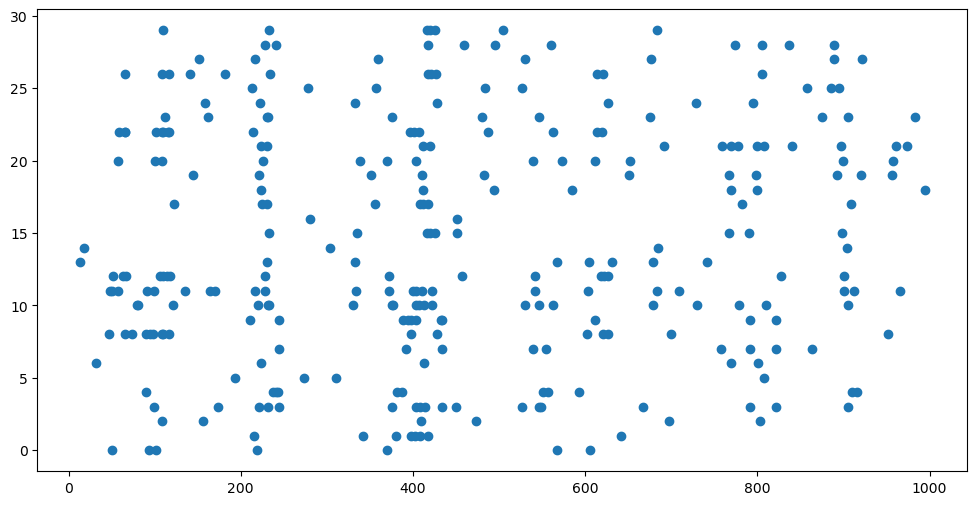

In [47]:
plt.figure(figsize=(12,6))
plt.scatter(*spikes)
plt.show()